check_ra_dec_cz_s_mu_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.199998 threshold = 10.000000


check_ra_dec_cz_s_mu_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.199999 threshold = 10.000000


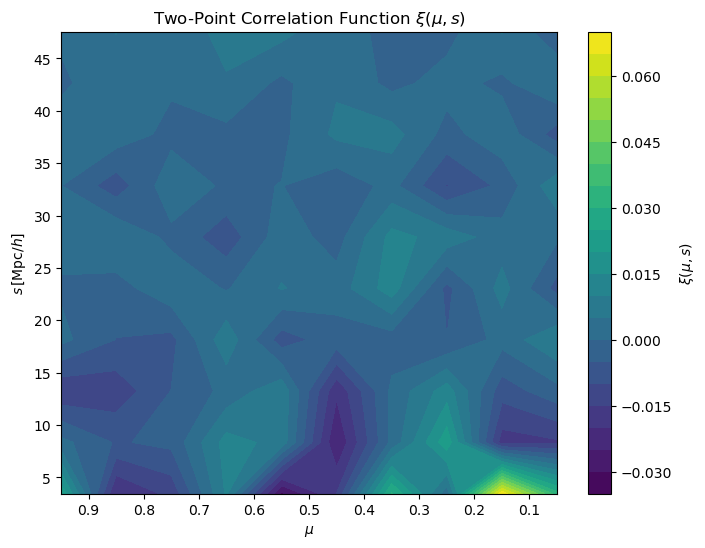

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

# Step 1: Generate mock data
def generate_mock_data(num_galaxies=10000, ra_range=(150, 180), dec_range=(0, 10), z_range=(0.1, 0.2)):
    """Generate mock galaxy data with RA, DEC in degrees and redshift."""
    ra = np.random.uniform(ra_range[0], ra_range[1], num_galaxies)
    dec = np.random.uniform(dec_range[0], dec_range[1], num_galaxies)
    redshift = np.random.uniform(z_range[0], z_range[1], num_galaxies)
    return ra, dec, redshift

# Step 2: Convert RA, DEC, z to Cartesian coordinates
# def redshift_to_comoving_distance(z, H0=70.0, Omega_m=0.3):
#     """Convert redshift to comoving distance using a flat Lambda-CDM model."""
#     from scipy.integrate import quad

#     c = 3e5  # Speed of light in km/s
#     E = lambda z: np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))
#     distance, _ = quad(lambda z: c / (H0 * E(z)), 0, z)
#     return distance

# def ra_dec_z_to_cartesian(ra, dec, z):
#     """Convert RA, DEC, and redshift to Cartesian coordinates (x, y, z)."""
#     ra_rad = np.radians(ra)
#     dec_rad = np.radians(dec)
#     comoving_distance = np.array([redshift_to_comoving_distance(zi) for zi in z])
#     x = comoving_distance * np.cos(dec_rad) * np.cos(ra_rad)
#     y = comoving_distance * np.cos(dec_rad) * np.sin(ra_rad)
#     z = comoving_distance * np.sin(dec_rad)
#     return x, y, z

# Step 3: Create random catalog
def generate_random_catalog(num_randoms, ra_range, dec_range, z_range):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    ra, dec, redshift = generate_mock_data(num_randoms, ra_range, dec_range, z_range)
    return ra, dec, redshift

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_mu_s(ra, dec, z, num_randoms=100000, bins=np.linspace(1, 50, 11), nmu_bins=10):
    """Calculate xi(mu, s) using Corrfunc."""
    # Convert RA, DEC, z to Cartesian coordinates
    # x, y, z = ra_dec_z_to_cartesian(ra, dec, z)

    # Generate random catalog
    ra_random, dec_random, z_random = generate_random_catalog(num_randoms, (150, 180), (0, 10), (0.1, 0.2))
    #x_random, y_random, z_random = ra_dec_z_to_cartesian(ra_random, dec_random, z_random)

    # Pair counts with Corrfunc
    DD_counts = DDsmu_mocks(1, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra, DEC1=dec, CZ1=z,\
            mu_max=1., nthreads=1)
    DR_counts = DDsmu_mocks(0, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra, DEC1=dec, CZ1=z, RA2=ra_random, DEC2=dec_random, CZ2=z_random,\
            mu_max=1., nthreads=1)
    RR_counts = DDsmu_mocks(1, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_random, DEC1=dec_random, CZ1=z_random,\
            mu_max=1., nthreads=1)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra), len(ra), len(ra_random), len(ra_random), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi

# Step 5: Plot xi(mu, s)
def plot_xi_mu_s(xi, bins, nmu_bins):
    """Plot xi(mu, s) as a heatmap."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins
    xi = xi.reshape(nmu_bins,len(s_bins))

    plt.figure(figsize=(8, 6))
    plt.imshow(xi.T, extent=(s_bins[0], s_bins[-1], 0, 1), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label=r'$\xi(\mu, s)$')
    plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.ylabel(r'$\mu$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.show()

# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  # Invert mu
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Generate mock data
    ra, dec, z = generate_mock_data()

    # Calculate xi(mu, s)
    bins = np.linspace(1, 50, 11)  # Separation bins in Mpc/h
    nmu_bins = 10  # Number of mu bins
    xi = calculate_xi_mu_s(ra, dec, z, bins=bins, nmu_bins=nmu_bins)

    # Plot xi(mu, s)
    plot_xi_mu_s_contours(xi, bins, nmu_bins)


### Now use the SDSS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 

# Step 1: Read data and randoms
def read_data(zmin=0.05,zmax=0.15):
    # Load your data and randoms as Pandas DataFrames
    sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
    sdss  = sdss[(sdss["red"] > zmin)&(sdss["red"] < zmax)]
    return sdss

def read_randoms():
    randoms = pd.read_csv('../data/random_sample_healpy_128_910159.csv') 
    return randoms


# Step 3: Create random catalog
def generate_random_catalog(num_randoms, ra_range, dec_range, z_range):
    """Generate a random catalog with uniform RA, DEC, and redshift."""
    ra, dec, redshift = generate_mock_data(num_randoms, ra_range, dec_range, z_range)
    return ra, dec, redshift

# Step 4: Run Corrfunc to compute xi(mu, s)
def calculate_xi_mu_s(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins, nmu_bins):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    DD_counts = DDsmu_mocks(1, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_data, DEC1=dec_data, CZ1=z_data,\
            mu_max=1., nthreads=1)
    DR_counts = DDsmu_mocks(0, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_data, DEC1=dec_data, CZ1=z_data, RA2=ra_rand, DEC2=dec_rand, CZ2=z_rand,\
            mu_max=1., nthreads=1)
    RR_counts = DDsmu_mocks(1, 1, binfile=bins, nmu_bins=nmu_bins, \
        RA1=ra_rand, DEC1=dec_rand, CZ1=z_rand,\
            mu_max=1., nthreads=1)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(ra_data), len(ra_data), len(ra_rand), len(ra_rand), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi

# # Step 5: Plot xi(mu, s)
# def plot_xi_mu_s(xi, bins, nmu_bins):
#     """Plot xi(mu, s) as a heatmap."""
#     s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
#     mu_bins = np.linspace(0, 1, nmu_bins + 1)
#     mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins
#     xi = xi.reshape(nmu_bins,len(s_bins))

#     plt.figure(figsize=(8, 6))
#     plt.imshow(xi.T, extent=(s_bins[0], s_bins[-1], 0, 1), origin='lower', aspect='auto', cmap='viridis')
#     plt.colorbar(label=r'$\xi(\mu, s)$')
#     plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
#     plt.ylabel(r'$\mu$')
#     plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
#     plt.show()

# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  # Invert mu
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Read data
    sdss = read_data()
    randoms = read_randoms()

    sdss = sdss.sample(n=10000)
    randoms = randoms[:10000]

    ra_data = sdss['ra'].values
    dec_data = sdss['dec'].values
    z_data = sdss['red'].values

    ra_rand = randoms['ra'].values
    dec_rand = randoms['dec'].values
    z_rand = randoms['red'].values

    # Calculate xi(mu, s)
    bins = np.linspace(50, 150, 20)  # Separation bins in Mpc/h
    nmu_bins = 19  # Number of mu bins
    xi = calculate_xi_mu_s(ra_data, dec_data, z_data, ra_rand, dec_rand, z_rand, bins=bins, nmu_bins=nmu_bins)

    # Plot xi(mu, s)
    plot_xi_mu_s_contours(xi, bins, nmu_bins)


check_ra_dec_cz_s_mu_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.149967 threshold = 10.000000
check_ra_dec_cz_s_mu_double> Out of range values found for cz. Expected input to be `cz' but found `z' instead. max_cz (found in input) = 0.149985 threshold = 10.000000


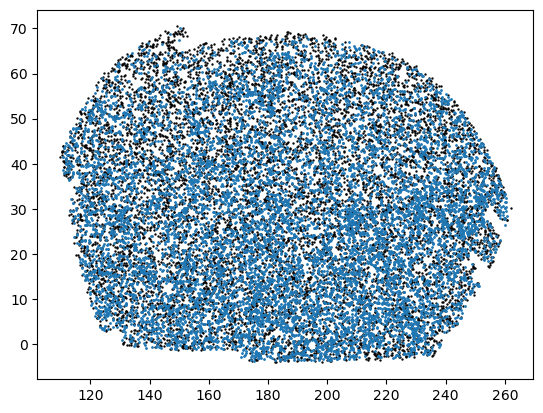

In [38]:

plt.scatter(ra_rand,dec_rand,s=0.5,c='k')
plt.scatter(ra_data,dec_data,s=1,c='C00')


In [35]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])